# Import and optimization

In [1]:
!pip install missingno phik boule osfclient cartopy pygeodesy

In [2]:
# !osf -p  8zvwm clone

In [3]:
# import urllib.request
# url = 'https://sourceforge.net/projects/geographiclib/files/geoids-distrib/egm2008-1.tar.bz2'
# filename = 'Data/egm2008-1.tar.bz2'
# urllib.request.urlretrieve(url, filename)

In [4]:
# ! tar  -xvf  Data/egm2008-1.tar.bz2

In [5]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import missingno
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
import phik
from pygeodesy import GeoidKarney, LatLon_

from sklearn.model_selection import train_test_split


In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
class CFG:
    TARGET = ['potential', 'delta_H']
    N_FOLDS = 5
    RANDOM_STATE = 3

    COLORADO_PATH = './Data/Colorado_gravity_data.dat'
    GRAVD_PATH = './Data/GRAVD_ms05_median_debiased_1hz.txt'

In [8]:
class DataLoader:
    def __init__(self, colorado: pd.DataFrame, gravd: pd.DataFrame):
        self.colorado = colorado
        self.gravd = gravd
        self.log_features = []  # Список признаков для трансформации
        self.X = None
        self.y = None
    

    @staticmethod
    def reduce_mem_usage(dataframe):
        """ 
        Уменьшает использование памяти dataframe путем преобразования типов данных
        с автоматическим пропуском временных столбцов
        """
        start_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Изначальное использование памяти: {start_mem:.2f} MB")
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype
            
            # Пропускаем временные столбцы и категориальные данные
            if str(col_type).startswith('datetime') or str(col_type) == 'category':
                continue
                
            if col_type != object:
                c_min = dataframe[col].min()
                c_max = dataframe[col].max()
                
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        dataframe[col] = dataframe[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        dataframe[col] = dataframe[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        dataframe[col] = dataframe[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        dataframe[col] = dataframe[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        dataframe[col] = dataframe[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        dataframe[col] = dataframe[col].astype(np.float32)
                    else:
                        dataframe[col] = dataframe[col].astype(np.float64)
            else:
                # Оптимизация строковых столбцов
                dataframe[col] = dataframe[col].astype('category')
        
        end_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Итоговое использование памяти: {end_mem:.2f} MB")
        print(f"Экономия {(start_mem - end_mem) / start_mem * 100:.1f}%")
        
        return dataframe


    def load(self, option='compare'):
        print(f'Loading data')
        print(f'Choosed option:{option}')

        if option == 'compare':
            self.colorado = self.colorado.merge(self.gravd, left_on='latitude(deg)', right_on='lat(deg)', how='outer')
        elif option == 'ground':
            pass

        self.colorado = self.reduce_mem_usage(self.colorado)

In [9]:
class DataAnalysis:

    @staticmethod
    def info_df(df: pd.DataFrame) -> None:
        print('------------------------------')
        print('| Dataset information |')
        print('------------------------------')
        df.info()
        print('-----------------------------------------')
        print('| First 5 rows |')
        print('-----------------------------------------')
        display(df.head())
        print('--------------------')
        print('| Sum of duplicates |')
        print('--------------------')
        print(df.duplicated().sum())


    @staticmethod
    def view_distribution(data: pd.DataFrame, object_col = False, numeric_col = False) -> None:
        numeric_cols = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        object_cols = data.select_dtypes(include=['object']).columns.to_list()
        
        if numeric_col:
            fig, axes = plt.subplots(nrows=len(data[numeric_cols].columns), ncols=2, figsize=(len(numeric_cols)+15,len(numeric_cols)+7))
            j = 0
            for i in data[numeric_cols].columns:
                sns.histplot(data[numeric_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black')
                axes[j, 0].set_title(i, fontsize=14)
                axes[j, 0].set_xlabel('')

                sns.boxplot(x=data[numeric_cols][i], ax=axes[j, 1], orient='h', palette='pink')
                axes[j, 1].set_title(i, fontsize=14)
                axes[j, 1].set_xlabel('')
                j += 1
            plt.suptitle(f'Num features\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.tight_layout();
            plt.show();

        if object_col:
            _,ax = plt.subplots(len(object_cols),1, figsize=(len(object_cols)+7,len(object_cols)+20));
            ax =ax.flatten();
            g = 0
            for k in data[object_cols].columns:
                sns.countplot(data=data, x=k,ax=ax[g]);
                ax[g].set_xticklabels(labels=ax[g].get_xticklabels());
                ax[g].set_title(k);
                ax[g].set_xlabel('');
                g += 1
            plt.suptitle(f'Categorical\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.show();


    @staticmethod
    def bloating_of_variance(data: pd.DataFrame) -> None:
        num = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        vif_data = pd.DataFrame()
        vif_data['feature'] = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

        vif_data['VIF'] = [variance_inflation_factor(data[num].values, i) \
                                for i in range(len(data[num].columns))]
        print(vif_data)
    
    @staticmethod
    def balance_of_target(data: pd.DataFrame, target: str) -> None:
        sns.countplot(y=target, data=data, color='green', width=0.6);

    @staticmethod
    def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
        # Set background color
        f, ax = plt.subplots(1, 2, figsize=(16, 7))
        plt.subplots_adjust(wspace=0.2)

        s1 = df[col].value_counts()
        N = len(s1)

        outer_sizes = s1
        inner_sizes = s1/N

        colors = sns.color_palette("mako")
        # hex_colors = [matplotlib.colors.to_hex(color) for color in colors]
        # print(hex_colors)
        
        outer_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        inner_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        #inner_colors = ['#59b3a3',] #'#433C64']

        ax[0].pie(
            outer_sizes,colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.3, 
            explode=([0.05]*(N-1) + [.3]),
            wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
            textprops={'fontsize': 12, 'weight': 'bold', 'color': 'white'}
        )

        textprops = {
            'size': 13, 
            'weight': 'bold', 
            'color': 'white'
        }

        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=1, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
            pctdistance=0.8, textprops=textprops
        )

        center_circle = plt.Circle((0,0), .68, color='black', fc='#243139', linewidth=0)
        ax[0].add_artist(center_circle)

        x = s1
        y = s1.index.tolist()
        sns.barplot(
            x=x, y=y, ax=ax[1],
            palette=colors, orient='horizontal'
        )

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(
            axis='x',         
            which='both',      
            bottom=False,       
            labelbottom=False
        )

        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='white', fontweight='bold', fontsize=12)

        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='white')
        ax[1].set_ylabel('count', fontweight="bold", color='white')

        f.suptitle(f'{title_name}', fontsize=14, fontweight='bold', color='white')
        plt.tight_layout() 
        plt.show()
    
    @staticmethod
    def summary(data: pd.DataFrame) -> None:
        data = data.select_dtypes(exclude=['object', 'datetime'])
        sum = pd.DataFrame(data.dtypes, columns=['dtypes'])
        sum['missing#'] = data.isna().sum()
        sum['missing%'] = (data.isna().sum())/len(data)
        sum['uniques'] = data.nunique().values
        sum['count'] = data.count().values
        sum['skew'] = data.skew().values
        return sum
    
    @staticmethod
    def correlations(data: pd.DataFrame) -> None:
        data = data.drop(columns=CFG.TARGET)
        plt.figure(figsize=(15, 13));
        # Generate a mask for the upper triangle
        mask_pir = np.triu(np.ones_like(data.corr(method='pearson'), dtype=bool));
        mask_spi = np.triu(np.ones_like(data.corr(method='spearman'), dtype=bool));
       
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9));

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True);
        plt.title('PIRSON')
        sns.heatmap(data.corr(method='pearson'), annot=True, mask=mask_pir, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True);
        plt.show();
        
        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        plt.title('SPEARMAN')
        sns.heatmap(data.corr(method='spearman'), annot=True, mask=mask_spi, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True)
        plt.show();

        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        
        interval_cols = data.select_dtypes(exclude='object').columns.to_list()
        phik_overview = data.phik_matrix(interval_cols=interval_cols)
        plt.title(r'$\phi_K$')
        corr = phik_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        significance_overview  = data.significance_matrix(interval_cols=interval_cols)

        plt.figure(figsize=(15, 13));
        plt.title('Statistical significance')
        corr = significance_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        plt.show()
    
    @staticmethod
    def blinks(data: pd.DataFrame) -> None:
        print('Data gaps')
        missingno.matrix(data)

In [10]:
loader = DataLoader(
    colorado=pd.read_csv(CFG.COLORADO_PATH, 
                      names=['latitude(deg)', 'longitude(deg)', 'orthometric height above MSL(m)', 'gravity(mGal)', 'survey ID', 'year'],
                        skipinitialspace=True,
                        sep=' '),
    gravd=pd.read_csv(CFG.GRAVD_PATH,
                        skipinitialspace=True),
)

In [11]:
loader.load(option='ground')

Loading data
Choosed option:ground
Изначальное использование памяти: 2.71 MB
Итоговое использование памяти: 0.79 MB
Экономия 70.8%


In [12]:
loader.colorado.head()

latitude(deg)  longitude(deg)  orthometric height above MSL(m)  \
0       37.06250         253.000                           2222.0   
1       37.06250         253.000                           2128.0   
2       37.03125         253.125                           2262.0   
3       37.03125         252.625                           1854.0   
4       37.03125         252.750                           1897.0   

   gravity(mGal)  survey ID  year  
0    979220.3125        746  9999  
1    979239.4375        746  9999  
2    979223.8750        746  9999  
3    979277.0625        746  9999  
4    979277.0625       5908  9999

In [13]:
loader.colorado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59303 entries, 0 to 59302
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   latitude(deg)                    59303 non-null  float16
 1   longitude(deg)                   59303 non-null  float16
 2   orthometric height above MSL(m)  59303 non-null  float16
 3   gravity(mGal)                    59303 non-null  float32
 4   survey ID                        59303 non-null  int16  
 5   year                             59303 non-null  int16  
dtypes: float16(3), float32(1), int16(2)
memory usage: 810.9 KB


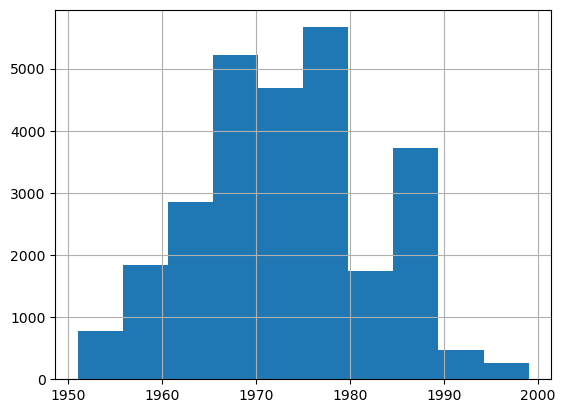

In [14]:
loader.colorado.query('year < 9999 and year > 1950')['year'].hist();

In [15]:
loader.colorado = loader.colorado.loc[(loader.colorado['year'] < 9999) & (loader.colorado['year'] > 1950)]

In [16]:
# for data in [loader.colorado]:
#     DataAnalysis.info_df(data)
#     DataAnalysis.blinks(data)
#     DataAnalysis.view_distribution(data, numeric_col=True)
#     DataAnalysis.correlations(data)

In [17]:
DataAnalysis.summary(loader.colorado).style.background_gradient(cmap='Blues')

In [18]:
loader.colorado.describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

In [19]:
loader.colorado.drop_duplicates(inplace=True)
loader.colorado.reset_index(drop=True, inplace=True)

# Features

In [20]:
FEATURES = ['latitude(deg)', 'longitude(deg)', 'orthometric height above MSL(m)', 'gravity(mGal)']
df = loader.colorado[FEATURES]
df.head()

latitude(deg)  longitude(deg)  orthometric height above MSL(m)  \
0       36.50000         250.500                           1631.0   
1       36.46875         250.625                           1747.0   
2       36.43750         250.750                           2144.0   
3       36.40625         250.750                           1904.0   
4       36.34375         250.750                           2084.0   

   gravity(mGal)  
0    979346.0000  
1    979328.1250  
2    979252.8750  
3    979303.6875  
4    979268.5000

In [21]:
geoidinterpolator=GeoidKarney('geoids/egm2008-1.pgm')

In [22]:
class Gravity:
    def __init__(self):
        pass


    @staticmethod
    def height_anomaly(B: float, L: float) -> float:
        ll = LatLon_(latlonh=B, lon=L, wrap=True) # преобразование в формат библиотеки pygeodesy
        h_anomaly = geoidinterpolator(ll)
        return h_anomaly
    
    
    @staticmethod
    def gamma_mean(B: float, L: float, H: float) -> float:
        # программа составлена по нормальным формулам для расчета силы тяжести, Огородова Л. В. "Высшая геодезия", 2006, стр 85, формула 3.65 и 3.74
        # параметры нормальной земли взяты из приказа "Об утверждении геометрических и физических числовых геодезических параметров
        # государственной геодезической системы координат 2011 года"
        # gamma_e=978032.696 # ГСК-2011
        # beta=0.00530243
        # beta1=0.00000585

        gamma_e=978032.67715 # GRS80
        beta=0.005302440112
        beta1=0.000004378
        norm_gravity_gradient=0.3086
        gamma_mean=gamma_e*(1-beta*np.sin(np.radians(B))**2-beta1*np.sin(2*np.radians(B))**2)-(H/2)*norm_gravity_gradient
        return gamma_mean
    
    def potential(g_mean: float, h_geodesy: float, B: float) -> float:

        GM = 3986005E8
        a = 6378137
        b = 6356752.3141
        w = 7292115E-11
        E = math.sqrt(a**2 + b**2)

        q = .5*((1+3*((h_geodesy**2)/E**2))*math.atan(E / h_geodesy) - 3* (h_geodesy/E))
        q0 = .5*((1+3*((h_geodesy**2)/E**2))*math.atan(E / b) - 3* (b/E)) 

        u_ellipsoid = ((GM) / E) * math.atan(E / h_geodesy) + .5*(w**2)*(a**2)*(q/q0)*((math.sin(B)**2) - 1/3) + .5*(w**2)*(h_geodesy**2 + E**2) * math.cos(B)**2

        return -(g_mean) * h_geodesy + u_ellipsoid
    
    def delta_h(lat: float, g_meas: float, g_mean: float):
        sin_lat = np.sin(np.radians(lat))
        gamma = (9.7803267715 * (1 + 0.00193185138639 * sin_lat**2) / np.sqrt(1 - 0.00669437999014 * sin_lat**2)) * 1e5
        a = 6378137

        return ((g_meas - g_mean) * a) / gamma

In [23]:
df['H_anomaly'] = np.vectorize(Gravity.height_anomaly)(df['latitude(deg)'], df['longitude(deg)'])

In [24]:
df['H_geodesy'] = df['orthometric height above MSL(m)'] + df['H_anomaly']

In [25]:
df['gamma_mean'] = np.vectorize(Gravity.gamma_mean)(df['latitude(deg)'], df['longitude(deg)'],df['H_geodesy'])

In [26]:
df['potential'] = np.vectorize(Gravity.potential)(df['gravity(mGal)'], df['H_geodesy'],np.radians(df['latitude(deg)']))

In [27]:
df['delta_H'] =  np.vectorize(Gravity.delta_h)(df['latitude(deg)'], df['gravity(mGal)'], df['gamma_mean'])

In [28]:
df['phi_0'] = 0.0

In [29]:
df.head()

latitude(deg)  longitude(deg)  orthometric height above MSL(m)  \
0       36.50000         250.500                           1631.0   
1       36.46875         250.625                           1747.0   
2       36.43750         250.750                           2144.0   
3       36.40625         250.750                           1904.0   
4       36.34375         250.750                           2084.0   

   gravity(mGal)  H_anomaly    H_geodesy     gamma_mean     potential  \
0    979346.0000 -20.664225  1610.335775  975945.420618 -1.507417e+09   
1    979328.1250 -20.269422  1726.730578  975930.167975 -1.621377e+09   
2    979252.8750 -19.840444  2124.159556  975871.550861 -2.010432e+09   
3    979303.6875 -19.763147  1884.236853  975911.276212 -1.775582e+09   
4    979268.5000 -19.668797  2064.331203  975888.895496 -1.951877e+09   

        delta_H  phi_0  
0  22135.111389    0.0  
1  22118.102867    0.0  
2  22009.896139    0.0  
3  22082.126032    0.0  
4  21998.884333    0.0

# Keras

In [30]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

In [31]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(df[['latitude(deg)', 'longitude(deg)', 'H_geodesy']])
y_scaled = scaler_y.fit_transform(df[CFG.TARGET])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2)

In [33]:
def create_custom_loss(df, gamma_col='gamma_mean', phi0_col='phi_0'):
    """
    Создает кастомную функцию потерь с учетом данных из датафрейма
    
    Параметры:
    df - датафрейм с эталонными значениями gamma и phi0
    gamma_col - название колонки с силой тяжести
    phi0_col - название колонки с базовым потенциалом
    """
    # Преобразуем нужные колонки в numpy массивы
    gamma_ref = df[gamma_col].values.astype('float32')
    phi0_ref = df[phi0_col].values.astype('float32')
    
    def custom_loss(y_true, y_pred):
        # y_true и y_pred: [потенциал φ, аномалия высоты Δh]
        y_true_pot, y_true_dh = y_true[0], y_true[1]
        y_pred_pot, y_pred_dh = y_pred[0], y_pred[1]
        
        # 1. MSE для потенциала и Δh
        mse_pot = tf.reduce_mean(tf.square(y_true_pot - y_pred_pot))
        mse_dh = tf.reduce_mean(tf.square(y_true_dh - y_pred_dh))
        
        # 2. Условие Лапласа (∇²φ = 0)
        temp_model = Model(inputs=model.inputs, outputs=model.outputs[0])
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(X_train)
            pred_pot = temp_model(X_train)
        
        grads = tape.gradient(pred_pot, X_train)
        laplacian = 0.0
        for i in range(3):
            grad_i = grads[:, i]
            grad_i_laplace = tape.gradient(grad_i, X_train)[:, i]
            laplacian += grad_i_laplace
        
        laplace_loss = tf.reduce_mean(tf.square(laplacian))
        
        # 3. Физическая связь с учетом данных из датафрейма
        # Преобразуем numpy массивы в тензоры
        gamma_tensor = tf.convert_to_tensor(gamma_ref, dtype=tf.float32)
        phi0_tensor = tf.convert_to_tensor(phi0_ref, dtype=tf.float32)
        
        # Вычисляем ожидаемую Δh по физической связи
        dh_physical = (y_pred_pot - phi0_tensor) / gamma_tensor
        physics_loss = tf.reduce_mean(tf.square(y_pred_dh - dh_physical))
        
        # 4. Дополнительное условие: соответствие предсказанного γ эталонному
        # Можно добавить, если модель также предсказывает γ
        # gamma_pred = ... 
        # gamma_loss = tf.reduce_mean(tf.square(gamma_pred - gamma_tensor))
        
        # Общая функция потерь
        return (mse_pot + mse_dh + 
                0.1 * laplace_loss + 
                0.1 * physics_loss) # +
                # 0.05 * gamma_loss)  # если добавлено
        
    return custom_loss

In [34]:
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_enhanced_model(hp):
    inputs = Input(shape=(3,))
    
    # Добавляем возможность выбора нормализации входных данных
    if hp.Boolean('input_batch_norm'):
        x = BatchNormalization()(inputs)
    else:
        x = inputs
    
    # Улучшенный блок скрытых слоев с дополнительными опциями
    for i in range(hp.Int('num_layers', 2, 5)):  # Увеличили диапазон слоев
        # Выбор количества нейронов
        units = hp.Int(f'units_{i}', min_value=64, max_value=512, step=32)
        
        # Выбор активации
        activation_choice = hp.Choice(f'activation_{i}', ['relu', 'tanh', 'leaky_relu', 'elu'])
        
        if activation_choice == 'leaky_relu':
            activation = LeakyReLU(alpha=0.1)
        else:
            activation = activation_choice
        
        x = Dense(units, activation=activation)(x)
        
        # Добавляем BatchNormalization
        if hp.Boolean(f'batch_norm_{i}'):
            x = BatchNormalization()(x)
        
        # Добавляем Dropout
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)
    
    # Выходные слои с возможностью индивидуальной настройки
    output_pot = Dense(1, 
                      name='potential',
                      kernel_regularizer=l1_l2(
                          l1=hp.Float('pot_l1', 0, 0.1),
                          l2=hp.Float('pot_l2', 0, 0.1)))(x)
    
    output_dh = Dense(1, 
                     name='delta_h',
                     kernel_regularizer=l1_l2(
                         l1=hp.Float('dh_l1', 0, 0.1),
                         l2=hp.Float('dh_l2', 0, 0.1)))(x)
    
    model = Model(inputs, [output_pot, output_dh])
    
    # Улучшенная настройка оптимизатора
    optimizer = Adam(
        learning_rate=hp.Float('lr', 1e-5, 1e-2, sampling='log'),
        clipvalue=hp.Float('clipvalue', 0.1, 1.0)
    )
    
    # Динамические веса для loss функций
    pot_weight = hp.Float('pot_weight', 0.1, 0.9)
    dh_weight = 1.0 - pot_weight
    
    model.compile(
        optimizer=optimizer,
        loss={'potential': 'mse', 'delta_h': 'mse'},
        loss_weights=[pot_weight, dh_weight],
        metrics={
            'potential': ['mae', 'mse'],
            'delta_h': ['mae', 'mse']
        }
    )
    
    return model

In [35]:
tuner = kt.Hyperband(
    build_enhanced_model,
    objective='val_loss',
    max_epochs=100,
    directory='enhanced_tuning_dir',
    project_name='enhanced_gravity_model',
    overwrite=True,
    factor=3,
    hyperband_iterations=2
)

In [36]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10,  
        restore_best_weights=True),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6)
]

# Запуск тюнинга
tuner.search(
    X_train, 
    {'potential': y_train[:, 0], 'delta_h': y_train[:, 1]},
    validation_data=(X_test, {'potential': y_test[:, 0], 'delta_h': y_test[:, 1]}),
    epochs=100,
    batch_size=64, 
    callbacks=callbacks,
    verbose=2
)

Trial 11 Complete [00h 00m 03s]
val_loss: 0.07394422590732574

Best val_loss So Far: 0.07256646454334259
Total elapsed time: 00h 00m 28s

Search: Running Trial #12

Value             |Best Value So Far |Hyperparameter
True              |False             |input_batch_norm
4                 |2                 |num_layers
320               |448               |units_0
relu              |relu              |activation_0
False             |True              |batch_norm_0
0.4               |0.1               |dropout_0
96                |224               |units_1
elu               |leaky_relu        |activation_1
True              |False             |batch_norm_1
0.2               |0.4               |dropout_1
0.080553          |0.0031657         |pot_l1
0.08968           |0.013388          |pot_l2
0.062692          |0.018259          |dh_l1
0.068455          |0.042984          |dh_l2
0.0015488         |0.00081883        |lr
0.33599           |0.26864           |clipvalue
0.48564           |

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.callbacks import (EarlyStopping, 
                                      ReduceLROnPlateau, 
                                      ModelCheckpoint,
                                      TensorBoard)

# Получаем лучшую модель
best_model = tuner.get_best_models(num_models=1)[0]

# Оптимальные callback'ы
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=25,  # Большой patience для тщательного обучения
        restore_best_weights=True,
        mode='min',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,  # Долгое ожидание перед уменьшением lr
        min_lr=1e-7,  # Очень маленький конечный learning rate
        verbose=1
    ),
    ModelCheckpoint(
        'best_gravity_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    TensorBoard(
        log_dir='logs/final_training',
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch'
    )
]

# Параметры обучения с максимальной точностью
history = best_model.fit(
    X_train,
    {'potential': y_train[:, 0], 'delta_h': y_train[:, 1]},
    validation_data=(X_test, {'potential': y_test[:, 0], 'delta_h': y_test[:, 1]}),
    epochs=1000,  # Очень большое число эпох (EarlyStopping остановит раньше)
    batch_size=16,  # Меньший batch size для лучшей точности
    callbacks=callbacks,
    verbose=2,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)

Epoch 1/1000

Epoch 1: val_loss improved from inf to 0.02190, saving model to best_gravity_model.h5


WARNING	absl:saving_api.py:save_model()- You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


1354/1354 - 9s - 6ms/step - delta_h_loss: 0.0525 - delta_h_mae: 0.1750 - delta_h_mse: 0.0525 - loss: 0.0716 - potential_loss: 0.0674 - potential_mae: 0.1928 - potential_mse: 0.0674 - val_delta_h_loss: 0.0169 - val_delta_h_mae: 0.1001 - val_delta_h_mse: 0.0170 - val_loss: 0.0219 - val_potential_loss: 0.0053 - val_potential_mae: 0.0593 - val_potential_mse: 0.0053 - learning_rate: 4.1376e-04
Epoch 2/1000

Epoch 2: val_loss did not improve from 0.02190
1354/1354 - 6s - 5ms/step - delta_h_loss: 0.0501 - delta_h_mae: 0.1715 - delta_h_mse: 0.0501 - loss: 0.0673 - potential_loss: 0.0633 - potential_mae: 0.1877 - potential_mse: 0.0633 - val_delta_h_loss: 0.0229 - val_delta_h_mae: 0.1224 - val_delta_h_mse: 0.0229 - val_loss: 0.0243 - val_potential_loss: 0.0087 - val_potential_mae: 0.0691 - val_potential_mse: 0.0087 - learning_rate: 4.1376e-04
Epoch 3/1000

Epoch 3: val_loss improved from 0.02190 to 0.01789, saving model to best_gravity_model.h5


WARNING	absl:saving_api.py:save_model()- You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


1354/1354 - 7s - 5ms/step - delta_h_loss: 0.0488 - delta_h_mae: 0.1695 - delta_h_mse: 0.0488 - loss: 0.0641 - potential_loss: 0.0599 - potential_mae: 0.1820 - potential_mse: 0.0599 - val_delta_h_loss: 0.0090 - val_delta_h_mae: 0.0752 - val_delta_h_mse: 0.0090 - val_loss: 0.0179 - val_potential_loss: 0.0047 - val_potential_mae: 0.0546 - val_potential_mse: 0.0047 - learning_rate: 4.1376e-04
Epoch 4/1000

Epoch 4: val_loss did not improve from 0.01789
1354/1354 - 6s - 5ms/step - delta_h_loss: 0.0472 - delta_h_mae: 0.1666 - delta_h_mse: 0.0472 - loss: 0.0623 - potential_loss: 0.0569 - potential_mae: 0.1772 - potential_mse: 0.0569 - val_delta_h_loss: 0.0184 - val_delta_h_mae: 0.1101 - val_delta_h_mse: 0.0184 - val_loss: 0.0295 - val_potential_loss: 0.0191 - val_potential_mae: 0.1100 - val_potential_mse: 0.0191 - learning_rate: 4.1376e-04
Epoch 5/1000

Epoch 5: val_loss did not improve from 0.01789
1354/1354 - 7s - 5ms/step - delta_h_loss: 0.0457 - delta_h_mae: 0.1635 - delta_h_mse: 0.0457 -

WARNING	absl:saving_api.py:save_model()- You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


1354/1354 - 6s - 5ms/step - delta_h_loss: 0.0315 - delta_h_mae: 0.1355 - delta_h_mse: 0.0315 - loss: 0.0428 - potential_loss: 0.0409 - potential_mae: 0.1497 - potential_mse: 0.0409 - val_delta_h_loss: 0.0112 - val_delta_h_mae: 0.0856 - val_delta_h_mse: 0.0111 - val_loss: 0.0161 - val_potential_loss: 0.0081 - val_potential_mae: 0.0727 - val_potential_mse: 0.0081 - learning_rate: 2.0688e-04
Epoch 22/1000

Epoch 22: val_loss did not improve from 0.01610
1354/1354 - 6s - 5ms/step - delta_h_loss: 0.0319 - delta_h_mae: 0.1355 - delta_h_mse: 0.0319 - loss: 0.0446 - potential_loss: 0.0439 - potential_mae: 0.1533 - potential_mse: 0.0439 - val_delta_h_loss: 0.0173 - val_delta_h_mae: 0.1082 - val_delta_h_mse: 0.0173 - val_loss: 0.0231 - val_potential_loss: 0.0141 - val_potential_mae: 0.0932 - val_potential_mse: 0.0141 - learning_rate: 2.0688e-04
Epoch 23/1000

Epoch 23: val_loss did not improve from 0.01610
1354/1354 - 7s - 5ms/step - delta_h_loss: 0.0312 - delta_h_mae: 0.1346 - delta_h_mse: 0.03

WARNING	absl:saving_api.py:save_model()- You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


1354/1354 - 6s - 5ms/step - delta_h_loss: 0.0306 - delta_h_mae: 0.1329 - delta_h_mse: 0.0306 - loss: 0.0427 - potential_loss: 0.0417 - potential_mae: 0.1503 - potential_mse: 0.0417 - val_delta_h_loss: 0.0067 - val_delta_h_mae: 0.0644 - val_delta_h_mse: 0.0067 - val_loss: 0.0155 - val_potential_loss: 0.0130 - val_potential_mae: 0.0928 - val_potential_mse: 0.0130 - learning_rate: 2.0688e-04
Epoch 26/1000

Epoch 26: val_loss improved from 0.01545 to 0.01484, saving model to best_gravity_model.h5


WARNING	absl:saving_api.py:save_model()- You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


1354/1354 - 6s - 5ms/step - delta_h_loss: 0.0331 - delta_h_mae: 0.1362 - delta_h_mse: 0.0331 - loss: 0.0431 - potential_loss: 0.0405 - potential_mae: 0.1466 - potential_mse: 0.0404 - val_delta_h_loss: 0.0122 - val_delta_h_mae: 0.0906 - val_delta_h_mse: 0.0121 - val_loss: 0.0148 - val_potential_loss: 0.0039 - val_potential_mae: 0.0493 - val_potential_mse: 0.0039 - learning_rate: 2.0688e-04
Epoch 27/1000
Epoch 27/1000

Epoch 27: val_loss did not improve from 0.01484
1354/1354 - 6s - 5ms/step - delta_h_loss: 0.0311 - delta_h_mae: 0.1347 - delta_h_mse: 0.0311 - loss: 0.0422 - potential_loss: 0.0407 - potential_mae: 0.1473 - potential_mse: 0.0407 - val_delta_h_loss: 0.0131 - val_delta_h_mae: 0.0923 - val_delta_h_mse: 0.0131 - val_loss: 0.0196 - val_potential_loss: 0.0148 - val_potential_mae: 0.0949 - val_potential_mse: 0.0148 - learning_rate: 2.0688e-04
Epoch 28/1000

Epoch 28: val_loss did not improve from 0.01484
1354/1354 - 6s - 5ms/step - delta_h_loss: 0.0300 - delta_h_mae: 0.1322 - del

In [ ]:
y_pred = best_model.predict(X_test)
phi_pred, dh_pred = y_pred[0], y_pred[1]

# Для денормализации нужно создать массив правильной формы
phi_pred_2d = np.column_stack((phi_pred, np.zeros_like(phi_pred)))
dh_pred_2d = np.column_stack((np.zeros_like(dh_pred), dh_pred))

phi_original = scaler_y.inverse_transform(phi_pred_2d)[:, 0]
dh_original = scaler_y.inverse_transform(dh_pred_2d)[:, 1]

print("Пример предсказаний:")
print("Потенциал (φ):", phi_original[:5])
print("Аномалия высоты (Δh):", dh_original[:5])

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Пример предсказаний:
Потенциал (φ): [-2.2888868e+09 -2.2191421e+09 -1.5490499e+09 -1.5183960e+09
 -2.6400412e+09]
Аномалия высоты (Δh): [23246.916 23001.615 20743.217 20663.98  23657.182]


In [ ]:
from plotly.offline import init_notebook_mode, plot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy.interpolate import griddata

# Инициализация
init_notebook_mode(connected=True)

# Подготовка данных
# Предсказанные значения (уже есть)
phi_pred = y_pred[0].flatten()
dh_pred = y_pred[1].flatten()

# Тестовые значения
phi_test = y_test[:, 0].flatten()
dh_test = y_test[:, 1].flatten()

# Денормализация тестовых значений
phi_test_2d = np.column_stack((phi_test, np.zeros_like(phi_test)))
dh_test_2d = np.column_stack((np.zeros_like(dh_test), dh_test))

phi_test_original = scaler_y.inverse_transform(phi_test_2d)[:, 0]
dh_test_original = scaler_y.inverse_transform(dh_test_2d)[:, 1]

# Разницы между предсказаниями и тестом
phi_diff = phi_original - phi_test_original
dh_diff = dh_original - dh_test_original

# Координаты для всех графиков
longitudes = X_test[:, 1].flatten()
latitudes = X_test[:, 0].flatten()

# Функция для создания поверхности
def create_surface(x, y, z, title, colorscale='Viridis'):
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(z)
    x, y, z = x[mask], y[mask], z[mask]
    
    grid_x, grid_y = np.mgrid[
        np.min(x):np.max(x):100j,
        np.min(y):np.max(y):100j
    ]
    
    try:
        grid_z = griddata(
            (x, y), z, (grid_x, grid_y), 
            method='cubic', fill_value=np.nanmean(z))
    except:
        grid_z = griddata(
            (x, y), z, (grid_x, grid_y), 
            method='linear', fill_value=np.nanmean(z))
    
    return go.Surface(
        x=grid_x, y=grid_y, z=grid_z,
        colorscale=colorscale, opacity=0.8,
        surfacecolor=grid_z, name=title
    )

# Создаем фигуру с 6 субплогами (2 ряда по 3 колонки)
fig = make_subplots(
    rows=2, cols=3,
    specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=(
        'Предсказанный потенциал', 'Тестовый потенциал', 'Разность потенциалов',
        'Предсказанная аномалия', 'Тестовая аномалия', 'Разность аномалий'
    ),
    horizontal_spacing=0.05,
    vertical_spacing=0.1
)

# Верхний ряд: потенциал
fig.add_trace(
    create_surface(longitudes, latitudes, phi_original, 'Предсказанный потенциал'),
    row=1, col=1
)
fig.add_trace(
    create_surface(longitudes, latitudes, phi_test_original, 'Тестовый потенциал'),
    row=1, col=2
)
fig.add_trace(
    create_surface(longitudes, latitudes, phi_diff, 'Разность потенциалов', 'RdBu'),
    row=1, col=3
)

# Нижний ряд: аномалия высоты
fig.add_trace(
    create_surface(longitudes, latitudes, dh_original, 'Предсказанная аномалия'),
    row=2, col=1
)
fig.add_trace(
    create_surface(longitudes, latitudes, dh_test_original, 'Тестовая аномалия'),
    row=2, col=2
)
fig.add_trace(
    create_surface(longitudes, latitudes, dh_diff, 'Разность аномалий', 'RdBu'),
    row=2, col=3
)

# Настройки макета
fig.update_layout(
    title_text='3D визуализация гравитационного поля: предсказания, тест и разности',
    scene=dict(
        xaxis_title='Долгота',
        yaxis_title='Широта',
        zaxis_title='Потенциал (м²/с²)'
    ),
    scene2=dict(
        xaxis_title='Долгота',
        yaxis_title='Широта',
        zaxis_title='Потенциал (м²/с²)'
    ),
    scene3=dict(
        xaxis_title='Долгота',
        yaxis_title='Широта',
        zaxis_title='Разность (м²/с²)'
    ),
    scene4=dict(
        xaxis_title='Долгота',
        yaxis_title='Широта',
        zaxis_title='Аномалия (м)'
    ),
    scene5=dict(
        xaxis_title='Долгота',
        yaxis_title='Широта',
        zaxis_title='Аномалия (м)'
    ),
    scene6=dict(
        xaxis_title='Долгота',
        yaxis_title='Широта',
        zaxis_title='Разность (м)'
    ),
    width=1700,
    height=1100,
    margin=dict(r=50, l=50, b=50, t=50)
)

# Сохраняем и отображаем
plot(fig, filename='gravity_field_comparison.html', auto_open=False)
fig.show()

In [ ]:
pd.DataFrame(dh_diff).describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[1])\
            .background_gradient(subset=['std'])\
            .background_gradient(subset=['50%'],)

In [ ]:
pd.DataFrame(phi_diff).describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[1])\
            .background_gradient(subset=['std'])\
            .background_gradient(subset=['50%'],)